In [1]:
!pip install torch_optimizer
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 import
import zipfile as zf
import os
import patoolib

import time
import copy
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from multiprocessing import cpu_count
from torch.utils.data import Subset
from PIL import Image
from torchvision.transforms import ColorJitter, RandomRotation
import torch_optimizer as optim
from torch.utils.data import Dataset

In [3]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 전체 데이터셋
files = zf.ZipFile("/content/drive/MyDrive/데이터 크리에이터 캠프/데이터셋.zip",'r')
files.extractall()
files.close()

In [ ]:
# train 데이터셋
os.makedirs("/content/health/train", exist_ok=True)
!unzip -O cp949 /content/kfood_health_train.zip -d /content/health/train

In [ ]:
# validation 데이터셋
os.makedirs("/content/health/val", exist_ok=True)
!unzip -O cp949 /content/kfood_health_val.zip -d /content/health/val

In [7]:
# 압축 확인
!ls

drive	kfood_health_train.zip	kfood_train.zip  sample_data
health	kfood_health_val.zip	kfood_val.zip	 validate_dist.ipynb


### **MISSION 3-1.**

- Mission2에서 학습시킨 모델을 활용하여 건강관리를 위한 음식 이미지 데이터를
13개의 클래스로 분류하는 모델을 만들고, 학습시킨다.
- HINT : transfer learning, linear probing,
fine-tuning, few-shot learning 등

In [8]:
# 데이터셋 로드
train_ds = ImageFolder('/content/health/train')
val_ds = ImageFolder('/content/health/val')

In [9]:
print(len(train_ds))
print(len(val_ds))

14115
1764


In [ ]:
# train 데이터셋을 train, validation으로 분할
random.seed(123)

train_ratio = 0.8
train_size = int(train_ratio * len(train_ds))
val_size = len(train_ds) - train_size

indices = list(range(len(train_ds)))                # 인덱스를 무작위로 섞어 무작위로 분할하도록 함
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = list(set(indices) - set(train_indices))
val_indices.sort()

train_dataset = Subset(train_ds, train_indices)
val_dataset = Subset(train_ds, val_indices)

print(len(train_dataset))
print(len(val_dataset))

11292
2823


In [ ]:
# Subset한 데이터에 이미지 변환을 적용하기 위해 사용자 정의 데이터셋 클래스 정의
class MyTransformDataset(Dataset):
    def __init__(self, dataset, transform=None):    # 클래스의 생성자, 데이터셋에 이미지 변환 적용
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# train 데이터에 대한 변환 설정 및 데이터셋 로드
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

train_dataset = MyTransformDataset(train_dataset, transform=train_transform)

In [ ]:
# validation, test 데이터에 대한 변환 설정 및 데이터셋 로드
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),                            # ResNet34의 가장 적합한 input size인 3*224*224으로 설정
    transforms.ToTensor(),                                    # 딥러닝 모델은 일반적으로 텐서 형태의 데이터를 입력하므로 텐서로 변환
    transforms.Lambda(lambda x: x * 2 -1)                     # Min-Max(-1~1) 스케일링 적용
])

val_dataset = MyTransformDataset(val_dataset, transform=valtest_transform)
test_dataset = ImageFolder('/content/health/val', transform=valtest_transform)

In [ ]:
# 데이터 로더 설정
BATCH_SIZE = 16                                                                 # 미니배치 크기를 16로 정의
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)      # 검증 데이터나 테스트 데이터는 모델의 성능을 평가하는데 사용되므로 무작위성을 추가하면
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)    # 모델 성능 평가에 영향을 미칠 수 있으므로 shuffle=false로 지정

In [ ]:
# 디바이스 및 환경 설정
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # DEVICE를 GPU가 사용 가능한 경우 'cuda'로, 그렇지 않은 경우 'cpu'로 설정
IMG_SIZE = (224, 224)                                                                 # 이미지 크기를 (224, 224)로 정의
LEARNING_RATE = 0.001                                                                 # 학습률을 0.001로 정의
NUM_CLASSES = 13                                                                      # 클래스 수를 13으로 정의
NUM_EPOCHS = 100                                                                      # 에포크 수를 100으로 정의
NUM_CPU = cpu_count()                                                                 # 사용 가능한 CPU 코어 수를 가져옴

In [16]:
# 새로운 클래스 수
num_classes = 13

# 모델 정의 (Mission2에서 학습한 모델을 로드)
model = torchvision.models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features

# 새로운 출력 레이어 정의
new_classifier = nn.Linear(num_ftrs, num_classes)

# 새로운 출력 레이어에 이전 가중치를 복사
checkpoint = torch.load('/content/drive/MyDrive/데이터 크리에이터 캠프/본선/checkpoint/M2_densenet121_final.pth', map_location=torch.device('cpu'))

# classifier.weight 및 classifier.bias의 크기 수정
# checkpoint['classifier.weight'] = checkpoint['classifier.weight'][:num_classes, :]
# checkpoint['classifier.bias'] = checkpoint['classifier.bias'][:num_classes]

# 모델에 새로운 출력 레이어 설정
model.classifier = new_classifier

# 모델의 가중치 로드
model.load_state_dict(checkpoint, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias', 'classifier.2.running_mean', 'classifier.2.running_var', 'classifier.2.num_batches_tracked', 'classifier.4.weight', 'classifier.4.bias'])

In [17]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")

Parameter name: features.conv0.weight
Parameter name: features.norm0.weight
Parameter name: features.norm0.bias
Parameter name: features.denseblock1.denselayer1.norm1.weight
Parameter name: features.denseblock1.denselayer1.norm1.bias
Parameter name: features.denseblock1.denselayer1.conv1.weight
Parameter name: features.denseblock1.denselayer1.norm2.weight
Parameter name: features.denseblock1.denselayer1.norm2.bias
Parameter name: features.denseblock1.denselayer1.conv2.weight
Parameter name: features.denseblock1.denselayer2.norm1.weight
Parameter name: features.denseblock1.denselayer2.norm1.bias
Parameter name: features.denseblock1.denselayer2.conv1.weight
Parameter name: features.denseblock1.denselayer2.norm2.weight
Parameter name: features.denseblock1.denselayer2.norm2.bias
Parameter name: features.denseblock1.denselayer2.conv2.weight
Parameter name: features.denseblock1.denselayer3.norm1.weight
Parameter name: features.denseblock1.denselayer3.norm1.bias
Parameter name: features.dense

In [18]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience=5, scheduler=None):
    # 스케줄러가 주어지면 스케줄러를 사용하고, 그렇지 않으면 사용하지 않도록 설정
    if scheduler:
        scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        model.train()
        running_train_loss = 0.0
        running_train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            running_train_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = running_train_corrects.double() / len(train_loader.dataset)

        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_train_loss, epoch_train_acc))

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            running_val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = running_val_corrects.double() / len(val_loader.dataset)

        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))
        print('-' * 30)

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        if scheduler:
            scheduler.step()

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'best_model_weights.pth')
            counter = 0
        else:
            counter += 1

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss

        if counter >= patience:
            print("Early stopping. Training stopped.")
            break

    print('Best Validation Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [19]:
# 새로운 분류 레이어를 설정
num_ftrs = model.classifier.in_features
new_classifier = nn.Linear(num_ftrs, 13)  # 13개의 클래스에 맞게 출력 레이어 설정
model.classifier = new_classifier

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()

# NAdam 옵티마이저를 생성하고 모델의 매개변수에 적용
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 스케줄러 설정
step_size = 7  # 스케줄을 적용할 스텝 크기
gamma = 0.1  # 학습률을 감소시키는 요소
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# 모델을 지정한 장치로 이동
model = model.to(DEVICE)

# 원하는 레이어만 업데이트할지 여부를 결정합니다.
for param in model.parameters():
    param.requires_grad = True # 모든 레이어는 가중치 업데이트

# 모델 훈련 (train_model 함수 호출 시 model 인자로 넘겨주어야 함)
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, NUM_EPOCHS, train_loader, val_loader, patience=5, scheduler=scheduler)

Epoch 1/100
Train Loss: 1.6736 Train Acc: 0.4431
Val Loss: 1.4376 Val Acc: 0.5236
------------------------------
Epoch 2/100
Train Loss: 1.3259 Train Acc: 0.5761
Val Loss: 1.1502 Val Acc: 0.6412
------------------------------
Epoch 3/100
Train Loss: 1.1480 Train Acc: 0.6278
Val Loss: 0.9615 Val Acc: 0.6922
------------------------------
Epoch 4/100
Train Loss: 1.0180 Train Acc: 0.6652
Val Loss: 0.8029 Val Acc: 0.7442
------------------------------
Epoch 5/100
Train Loss: 0.9549 Train Acc: 0.6844
Val Loss: 0.7198 Val Acc: 0.7609
------------------------------
Epoch 6/100
Train Loss: 0.8780 Train Acc: 0.7117
Val Loss: 0.6505 Val Acc: 0.7793
------------------------------
Epoch 7/100
Train Loss: 0.8089 Train Acc: 0.7325
Val Loss: 0.5238 Val Acc: 0.8204
------------------------------
Epoch 8/100
Train Loss: 0.6389 Train Acc: 0.7934
Val Loss: 0.3861 Val Acc: 0.8704
------------------------------
Epoch 9/100
Train Loss: 0.5943 Train Acc: 0.8023
Val Loss: 0.3604 Val Acc: 0.8781
--------------

In [20]:
# 가장 좋은 모델 저장
best_model_path = '/content/drive/MyDrive/데이터 크리에이터 캠프/본선/checkpoint/M3_densenet121_final.pth'  # 저장할 모델 파일 경로
torch.save(model.state_dict(), best_model_path)

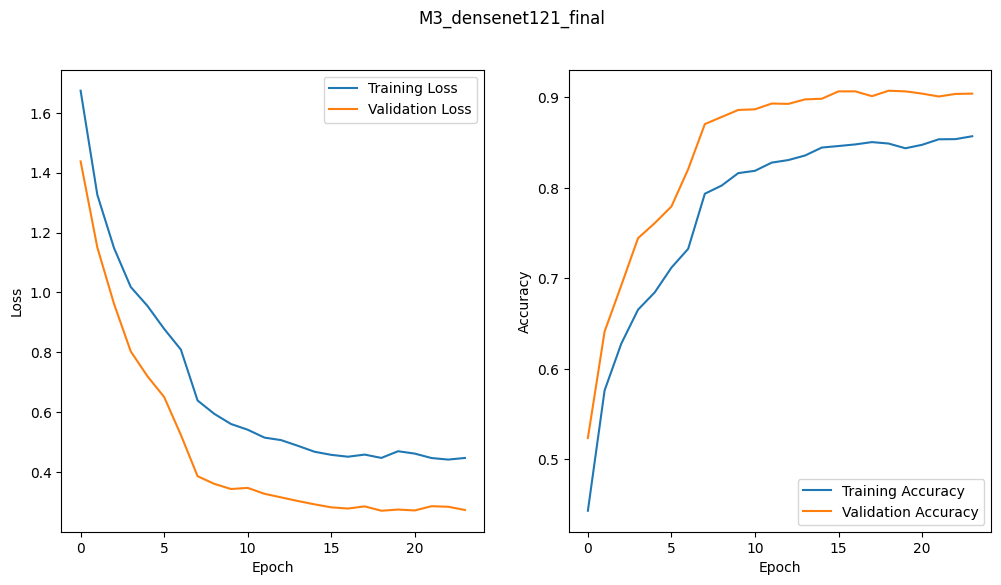

In [21]:
# 훈련 과정 시각화
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.suptitle("M3_densenet121_final")

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

train_accuracies = [acc.to('cpu').item() for acc in train_accuracies]
val_accuracies = [acc.to('cpu').item() for acc in val_accuracies]

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Validation accuracy 측정 함수 정의 (제공된 코드 사용)
@torch.no_grad()
def validate_epoch(model, data_loader, device):
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.cat(accuracies).float().mean() * 100
    return accuracy.item()

In [23]:
# 정확도 측정
test_accuracy = validate_epoch(model, test_loader, DEVICE)
print(f'\ntest Accuracy: {test_accuracy:.2f}%')

measuring accuracy: 100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


test Accuracy: 88.95%


Creating Confusion Matrix: 100%|██████████| 111/111 [00:53<00:00,  2.08it/s]


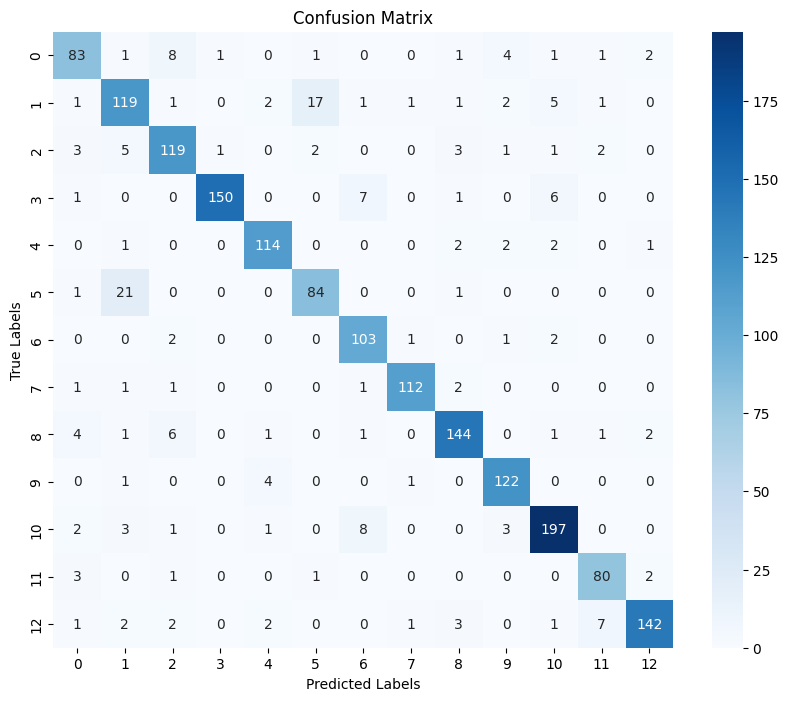

In [24]:
# 테스트 데이터에서 검증 및 혼동 행렬 시각화
def validate_and_plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in tqdm(test_loader, total=len(test_loader), desc='Creating Confusion Matrix'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

validate_and_plot_confusion_matrix(model, test_loader, DEVICE)

Creating Confusion Matrix: 100%|██████████| 177/177 [01:26<00:00,  2.05it/s]


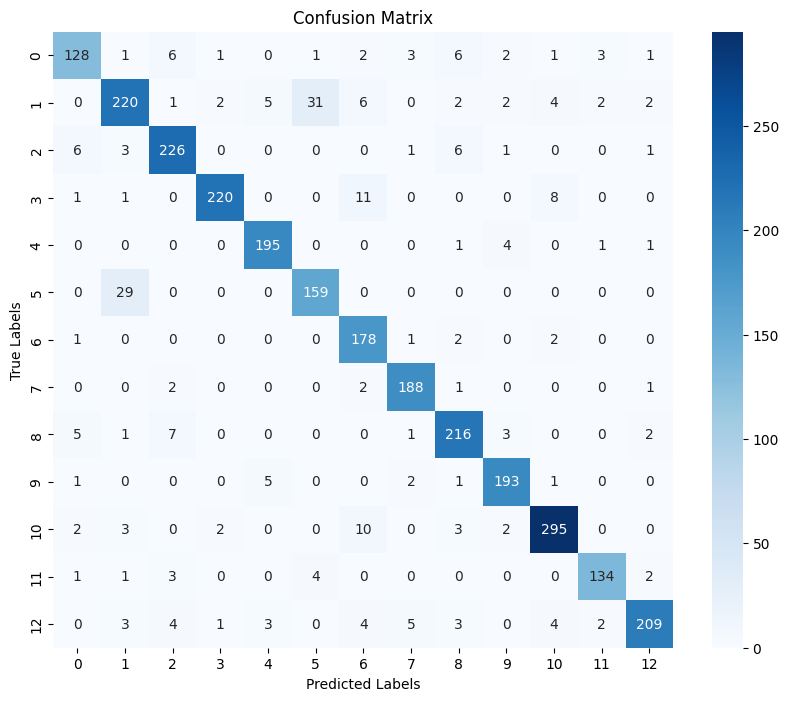

In [25]:
# 검증 데이터에서 검증 및 혼동 행렬 시각화
def validate_and_plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in tqdm(test_loader, total=len(test_loader), desc='Creating Confusion Matrix'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

validate_and_plot_confusion_matrix(model, val_loader, DEVICE)